In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data Preparation

In [104]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [105]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [106]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
x_dev,x_test,y_dev,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

#train 0.6
#dev 0.2
#test 0.2

In [107]:
#norm


scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_dev=scaler_x.transform(x_dev)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_dev=scaler_y.transform(y_dev.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))


### Tests

In [239]:
#same number of epochs with the traditional approach i get overfit, runs five times faster tho...
epochs=2000
model_nn = MLPRegressor(hidden_layer_sizes=(2,2,2),
                        max_iter=epochs,
                        solver='adam',
                        activation='tanh',
                        random_state=42,)

#fit
model_nn.fit(x_train,y_train.ravel())

#get predictions
test_pred=model_nn.predict(x_test)
dev_pred=model_nn.predict(x_dev)
train_pred=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred)
dev_mse=mean_squared_error(y_dev,dev_pred)
train_mse=mean_squared_error(y_train,train_pred)

print('train mse: ' +str(train_mse)+'\n'+'dev mse: ' +str(dev_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.18834316134991655
dev mse: 0.2270800350272283
test mse: 0.16872976923418345


In [240]:
(train_mse-dev_mse)/dev_mse*100

-17.05868755598305

Text(0.5, 1.0, "Before 'boruta'")

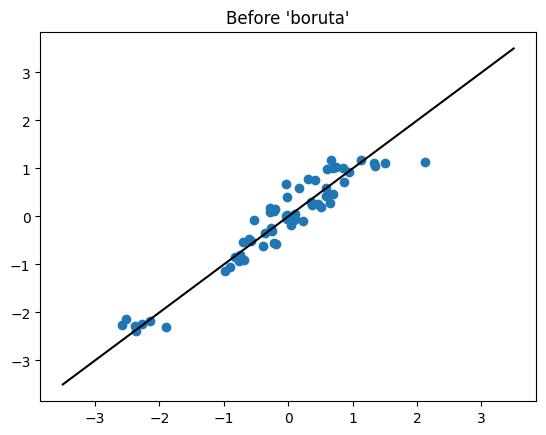

In [203]:
#parity on test set
plt.scatter(y_test, test_pred)
plt.plot([-3.5,3.5],[-3.5,3.5],'black')
plt.title('Before \'boruta\'')

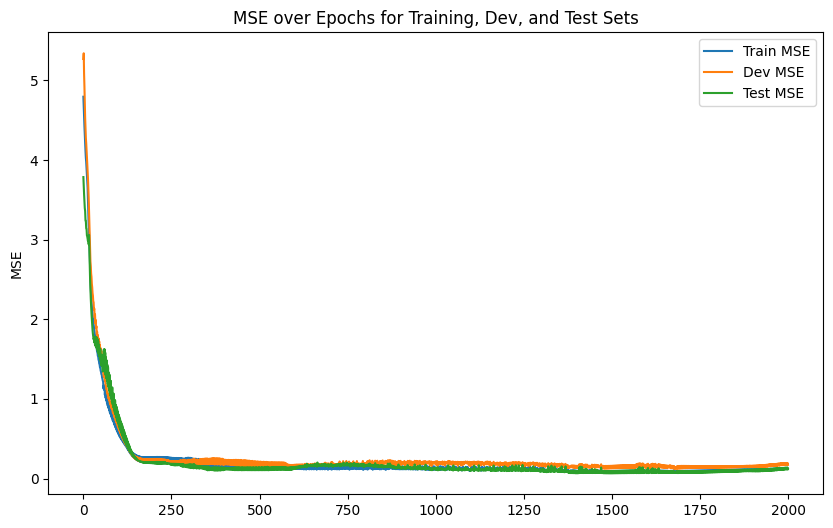

In [204]:
##learning curves
epochs=2000
model_nn = MLPRegressor(hidden_layer_sizes=(2,2),
                        max_iter=1,
                        solver='adam',
                        activation='tanh',
                        random_state=42,
                        warm_start=True)

train_mse_arr=[]
dev_mse_arr=[]
test_mse_arr=[]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",
                            category=ConvergenceWarning,
                            module="sklearn")

    for epoch_num in range(epochs):
        model_nn.fit(x_train,y_train.ravel())
        
        train_pred=model_nn.predict(x_train)
        dev_pred=model_nn.predict(x_dev)
        test_pred=model_nn.predict(x_test)
        
        train_mse=mean_squared_error(y_train,train_pred)
        dev_mse=mean_squared_error(y_dev,dev_pred)
        test_mse=mean_squared_error(y_test,test_pred)
        
        train_mse_arr.append(train_mse)
        dev_mse_arr.append(dev_mse)
        test_mse_arr.append(test_mse)


plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_mse_arr, label='Train MSE')
plt.plot(range(epochs), dev_mse_arr, label='Dev MSE')
plt.plot(range(epochs), test_mse_arr, label='Test MSE')
plt.ylabel('MSE')
plt.title('MSE over Epochs for Training, Dev, and Test Sets')
plt.legend()
plt.show()
    
    

### Importance evaluation Holdout/External validation


In [241]:
def eval_importance_holdout(architecture,fitX,fitY,importanceX,importanceY):
    importance_df=pd.DataFrame()
    
    for structure_nn in architecture:
        
        # Train MLPRegressor
        model_nn = MLPRegressor(hidden_layer_sizes=structure_nn,
                        max_iter=2000,
                        solver='adam',
                        activation='tanh',
                        random_state=42,)

        
        model_nn.fit(fitX, fitY.ravel())

        # Perform permutation importance
        results = permutation_importance(model_nn, importanceX, importanceY, n_repeats=30, random_state=42, n_jobs=4,scoring='neg_mean_squared_error')
        
        # Get the importance of the features
        importance = results.importances_mean
        
        #replace negative values by zero
        importance[importance<0]=0
        
        #norm
        scaler=MinMaxScaler()
        importance=scaler.fit_transform(importance.reshape(-1,1)).flatten()
    
        importance_df['layers'+str(structure_nn)]=importance
    return importance_df

In [242]:
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4)]
importance_holdout=eval_importance_holdout(architecture=layers,
                                           fitX=x_train,
                                           fitY=y_train,
                                           importanceX=x_train,
                                           importanceY=y_train)

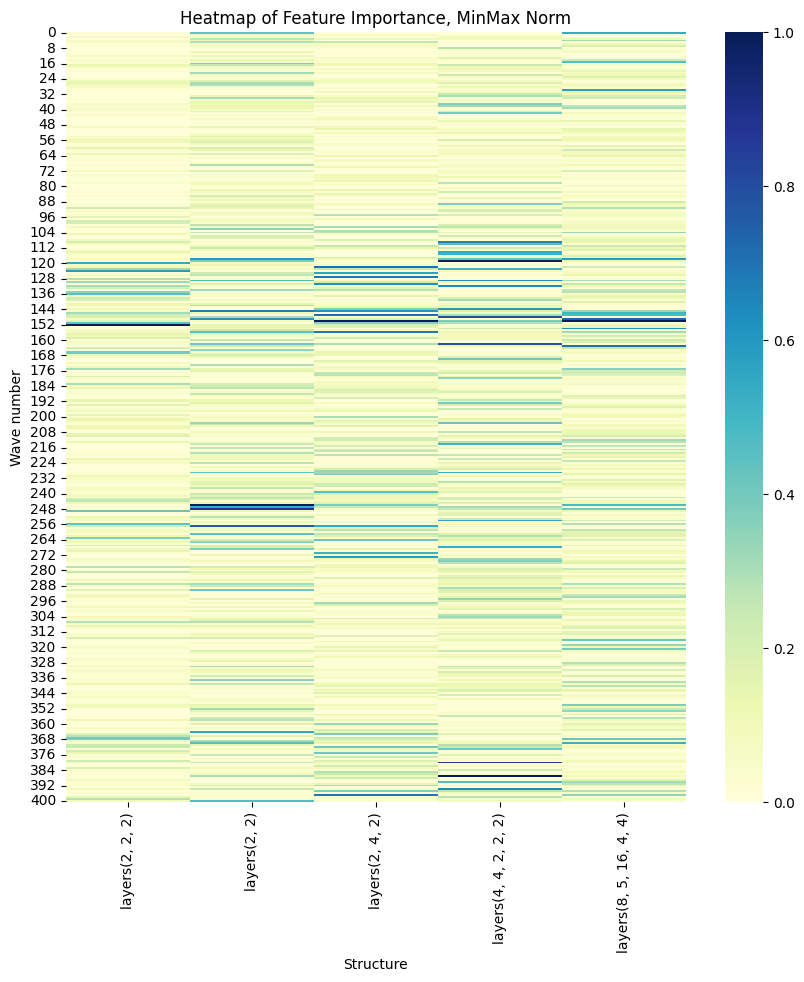

In [243]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_holdout, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance, MinMax Norm')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()


### benchmarking Holdout

In [208]:
def print_long(frame):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,):
     print(frame)

In [232]:
#turn into function?

#dev MSE for different models with various thresholds(i)

#get some values for different training
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_dev=pd.DataFrame(x_dev)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.4,0.05):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_holdout.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_dev_important=x_dev[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=2000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        
        dev_pred_important=model_nn.predict(x_dev_important)
        dev_mse_i = mean_squared_error(y_dev, dev_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = dev_mse_i

In [233]:
stored

,"layers(2, 2, 2)","layers(2, 2)","layers(2, 4, 2)","layers(4, 4, 2, 2, 2)","layers(8, 5, 16, 4, 4)"
0.00,0.227080,0.109826,0.246253,0.205021,0.125931
0.05,0.129309,0.155307,0.185209,0.272568,0.147931
0.10,0.103092,0.173918,0.073286,0.339980,0.087683
0.15,0.142512,0.084404,0.057490,0.168353,0.146437
0.20,0.154312,0.176500,0.109389,0.130537,0.076723
0.25,0.249639,0.113088,0.146741,0.138678,0.079968
0.30,0.196282,0.131323,0.159294,0.140729,0.120539
0.35,0.309994,0.167753,0.128322,0.115480,0.179988


In [244]:
# all sets mse for different tresholds

structure=(2,2,2)
columns=['threshold','train mse','dev mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,0.3,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_holdout.T.loc['layers'+str(structure),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train[columns_to_keep]
    x_dev_important=x_dev[columns_to_keep]
    x_test_important=x_test[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=structure,
                           max_iter=2000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    dev_pred_important=model_nn.predict(x_dev_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    dev_mse_i=mean_squared_error(y_dev,dev_pred_important)
    test_mse_i = mean_squared_error(y_test, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,dev_mse_i,test_mse_i,num_features]

In [245]:
stored_2

,threshold,train mse,dev mse,test mse,wavelengths included
0.00,0.00,0.188343,0.227080,0.168730,401.0
0.01,0.01,0.072917,0.124855,0.078521,304.0
0.02,0.02,0.059339,0.121501,0.077468,254.0
0.03,0.03,0.231320,0.310839,0.289580,217.0
0.04,0.04,0.128688,0.164560,0.142107,184.0
0.05,0.05,0.068504,0.129309,0.084726,168.0
0.06,0.06,0.233946,0.321576,0.234518,150.0
0.07,0.07,0.212050,0.278725,0.225471,130.0
0.08,0.08,0.105251,0.135145,0.086295,122.0
0.09,0.09,0.063150,0.114630,0.077840,108.0


### benchmarking Cross

In [48]:
#data split and normalisation
x_train_cv,x_test_cv,y_train_cv,y_test_cv=train_test_split(X,Y,test_size=0.8,random_state=42)

#train 0.8
#test 0.2



In [49]:

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train_cv)
x_train_cv=scaler_x.transform(x_train_cv)
x_test_cv=scaler_x.transform(x_test_cv)

scaler_y=StandardScaler()
scaler_y.fit(y_train_cv.values.reshape(-1,1))
y_train_cv=scaler_y.transform(y_train_cv.values.reshape(-1,1))
y_test_cv=scaler_y.transform(y_test_cv.values.reshape(-1,1))

In [51]:
#evaluate importance in each fold then take mean
layers = [(2,)]

importance_df_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    fold_importance=np.zeros((x_train_cv.shape[1],kf.n_splits))
    
    for fold, (train_index, test_index) in enumerate(kf.split(x_train_cv)):
        
        
        x_train_fold=x_train_cv.iloc[train_index]
        x_val_fold=x_train_cv.iloc[test_index]
        y_train_fold=y_train_cv[train_index]
        y_val_fold=y_train_cv[test_index]
        
        #modelo
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=10000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)
        
        model_nn.fit(x_train_fold,y_train_fold.ravel())
        #permutation importance
        results=permutation_importance(model_nn,x_val_fold,y_val_fold,n_repeats=10,random_state=42, n_jobs=4)
        
        fold_importance[:,fold]=results.importances_mean
        
    #get average among kfolds
    mean_importance=fold_importance.mean(axis=1)
    
    #zero out neg values
    #mean_importance[mean_importance<0]=0
    
    #norm
    #scaler=MinMaxScaler()
    #norm_importance=scaler.fit_transform(mean_importance.reshape(-1,1)).flatten()
    
    #store to frame
    importance_df_cross['layers'+str(structure)]=mean_importance
    

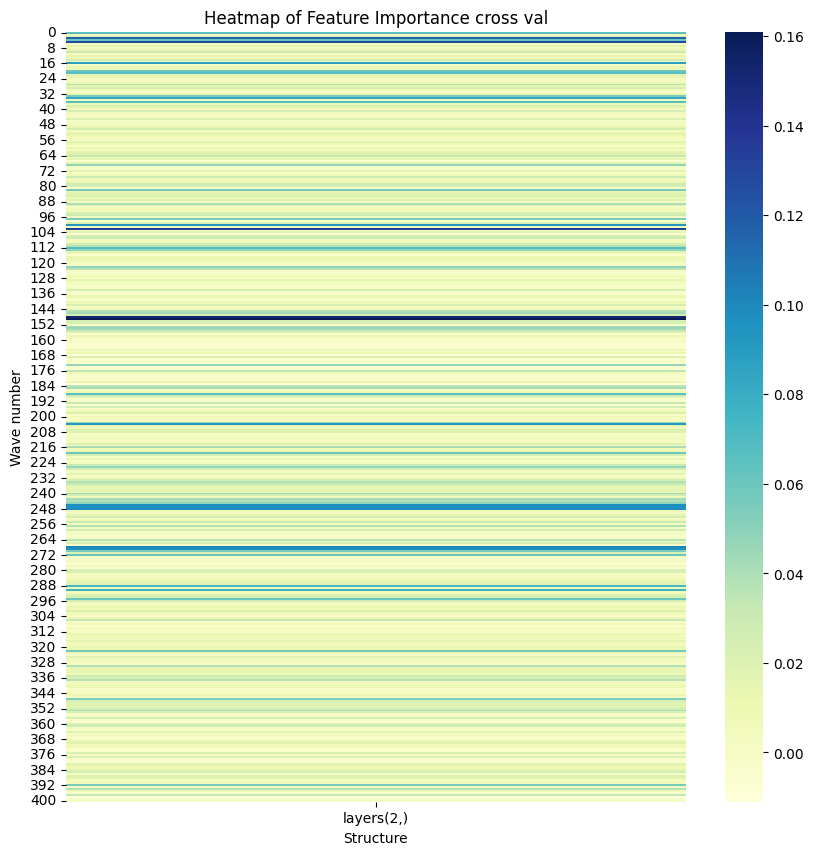

In [52]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df_cross, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance cross val')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()

In [196]:
#turn into function?

#dev MSE for different models with various thresholds(i) CROSS

#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored = pd.DataFrame()

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    for i in np.arange(0,0.1,0.005):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df_cross.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train_cv[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=10000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train_cv.ravel())
        
        train_pred_important=model_nn.predict(x_train_important)
        train_mse_i = mean_squared_error(y_train_cv, train_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = train_mse_i

In [197]:
stored

,"layers(2,)","layers(2, 2)","layers(2, 2, 2)","layers(4,)","layers(4, 4)","layers(4, 4, 4)"
0.000,0.263141,0.277322,0.293774,0.262322,0.262368,0.262985
0.005,0.252681,0.260570,0.275060,0.261751,0.267731,0.266611
0.010,0.272561,0.281911,0.263544,0.265965,0.255135,0.269921
0.015,0.275120,0.275914,0.274365,0.293681,0.266870,0.265324
0.020,0.272432,0.286541,0.269784,0.258993,0.265831,0.266467
0.025,0.267129,0.272734,0.270782,0.251050,0.262290,0.267772
0.030,0.280525,0.266190,0.290718,0.253685,0.263578,0.264541
0.035,0.282246,0.259464,0.269514,0.255544,0.264913,0.257250
0.040,0.254366,0.255691,0.285101,0.258248,0.275872,0.273152
0.045,0.270644,0.259224,0.286535,0.254259,0.269284,0.291514


In [184]:
# all sets mse for different tresholds

columns=['threshold','train mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,1.0,0.1):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_df_cross.T.loc['layers'+str((2,)),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train_cv[columns_to_keep]
    x_test_important=x_test_cv[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=(2,),
                           max_iter=10000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train_cv.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train_cv,train_pred_important)
    test_mse_i = mean_squared_error(y_test_cv, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,test_mse_i,num_features]

In [185]:
stored_2

,threshold,train mse,test mse,wavelengths included
0.0,0.0,0.263141,0.284717,401.0
0.1,0.1,0.273336,0.290438,53.0
0.2,0.2,0.269599,0.287571,20.0
0.3,0.3,0.288593,0.303320,14.0
0.4,0.4,0.282179,0.297774,9.0
0.5,0.5,0.275347,0.292644,8.0
0.6,0.6,0.261454,0.285533,4.0
0.7,0.7,0.261454,0.285533,4.0
0.8,0.8,0.293233,0.306912,3.0
0.9,0.9,0.270607,0.290896,2.0


In [63]:
#cross to evaluate importance and cross validation with important features
#this manner sort of dilutes the results and i can't find the better model...
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)



for structure in layers:
    
    for i in np.arange(0,0.9,0.15):
        
        fold_scores=np.empty(5)
    
        for fold, (train_index,test_index) in enumerate(kf.split(X)):
            
            x_train_fold,x_val_fold=X.iloc[train_index],X.iloc[test_index]
            y_train_fold,y_val_fold=Y[train_index],Y[test_index]

            #get indexing of only features with importance over i over layer 'structure'
            importance=importance_df_cross.T.loc['layers'+str(structure),:]
            mask=importance>=i
            
            #slice of important features
            columns_to_keep=mask[mask].index
            x_train_important=x_train_fold[columns_to_keep]
            x_val_important=x_val_fold[columns_to_keep]
            
            #get predictions
            model_nn=MLPRegressor(hidden_layer_sizes=structure,
                                max_iter=10000,
                                random_state=42,)

            #fit pred and mean squared error
            
            model_nn.fit(x_train_important,y_train_fold.ravel())
            
            val_pred_important=model_nn.predict(x_val_important)
            
            test_mse_i = mean_squared_error(y_val_fold, val_pred_important)
            
            fold_scores[fold]=test_mse_i
            
            
        #store
        stored_cross.loc[i,'layers'+str(structure)] = fold_scores.mean()